In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import spacy

In [4]:
filmes = pd.read_csv("../../../dados/imdb-reviews-pt-br.csv")

In [5]:
filmes["classify"] = filmes["sentiment"].replace(["neg", "pos"], [0, 1])

In [6]:
filmes["text_minus"] = filmes["text_pt"].str.lower()

In [7]:
filmes["text_no_enter"] = filmes["text_minus"].replace(["\n", "\r", "\t"], [' ', ' ', ' '])

In [8]:
import string
mytrans = str.maketrans("", "", string.punctuation)
filmes["text_no_punct"] = filmes["text_no_enter"].str.translate(mytrans)

## Remove os acentos

In [9]:
from unidecode import unidecode

In [10]:
filmes["text_no_accent"] = filmes["text_no_punct"].apply(unidecode)

## Remove as Stop Words

In [11]:
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Antonio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
palavras_adicionais = ['entao', 'apenas', 'historia', 'enquanto', 'ainda', 'agora', 'porque', 'filme', 'filmes', '', 
                       'pode', 'ter', 'anos', 'qualquer', 'vez', 'realmente', 'pessoas', 'todos', 'tempo', 'tao', 'sobre',
                       'sao', 'voce', 'nao', 'parece']
stop_words.extend(palavras_adicionais)
stop_words.sort()

In [13]:
def remove_stop_words( texto ): 
    global stop_words
    lista_palavras = texto.split(" ")
    nova_lista = []
    for palavra in lista_palavras:
        if palavra not in stop_words:
            nova_lista.append(palavra)
    return " ".join(nova_lista)

In [14]:
filmes["texto_no_stopwords"] = filmes["text_no_accent"].apply(remove_stop_words)

## Aplicar a lemmatization

In [48]:
nlp = spacy.load('pt_core_news_sm')

In [49]:
counter = 0
def return_lemma( texto ):
    global counter
    nova_lista = []
    doc = nlp( texto )
    counter += 1
    if counter % 1000 == 0:
        print("Processando linha: ", counter)
    for token in doc:
        nova_lista.append(token.lemma_)
    return " ".join(nova_lista)

In [ ]:
filmes["texto_lemma"] = filmes["texto_no_stopwords"].apply(return_lemma)

Processando linha:  1000
Processando linha:  2000
Processando linha:  3000


## Aplicar a stemming

In [18]:
stemmer = nltk.RSLPStemmer()

In [19]:
counter = 0
def entroncamento( texto ):
    global counter
    counter += 1
    if counter % 1000 == 0:
        print("Processando linha: ", counter)
    lista_palavras = texto.split(" ")
    nova_lista = []
    for palavra in lista_palavras:
        if len(palavra) > 0:
            nova_lista.append( stemmer.stem(palavra) )
    return " ".join(nova_lista)

In [20]:
filmes["text_stemmed"] = filmes["texto_no_stopwords"].apply( entroncamento )

Processando linha:  1000
Processando linha:  2000
Processando linha:  3000
Processando linha:  4000
Processando linha:  5000
Processando linha:  6000
Processando linha:  7000
Processando linha:  8000
Processando linha:  9000
Processando linha:  10000
Processando linha:  11000
Processando linha:  12000
Processando linha:  13000
Processando linha:  14000
Processando linha:  15000
Processando linha:  16000
Processando linha:  17000
Processando linha:  18000
Processando linha:  19000
Processando linha:  20000
Processando linha:  21000
Processando linha:  22000
Processando linha:  23000
Processando linha:  24000
Processando linha:  25000
Processando linha:  26000
Processando linha:  27000
Processando linha:  28000
Processando linha:  29000
Processando linha:  30000
Processando linha:  31000
Processando linha:  32000
Processando linha:  33000
Processando linha:  34000
Processando linha:  35000
Processando linha:  36000
Processando linha:  37000
Processando linha:  38000
Processando linha:  3

## Atribui a variavel que conterá os textos finais

In [44]:
textos = filmes["text_stemmed"]

## Visualiza as top 20 palavras para identificar novas stop words

In [45]:
dicionario = {}
counter = 0
def criar_dicionario( texto ):
    global dicionario, counter
    termos = texto.split(" ")
#     if counter % 1000 == 0:
#         print("Executando linha: ", counter)
    counter += 1
    for termo in termos:
        if termo in dicionario:
            dicionario[termo] += 1
        else:
            dicionario[termo] = 1
    return texto   

In [46]:
textos.apply(criar_dicionario)

0        sr costner arrumou necessario alem terriveis s...
1        exemplo motivo maioria acao mesmos generico ch...
2        primeiro tudo odeio raps imbecis poderiam agir...
3        beatles puderam escrever musicas gostassem emb...
4        fotos latao palavra apropriada verdade tanto o...
                               ...                        
49454    media votos baixa fato funcionario locadora ac...
49455    enredo algumas reviravoltas infelizes inacredi...
49456    espantado forma maioria outros media 5 estrela...
49457    christmas together veio antes criado john denv...
49458    drama romantico classe trabalhadora diretor ma...
Name: texto_no_stopwords, Length: 49459, dtype: object

In [47]:
len(dicionario.keys())

157490

In [36]:
dicionario_df = pd.DataFrame( {"palavras": list(dicionario.keys()), "frequencias": list(dicionario.values()) } )

In [37]:
top_20 = dicionario_df.nlargest(columns="frequencias", n=20)

<BarContainer object of 20 artists>

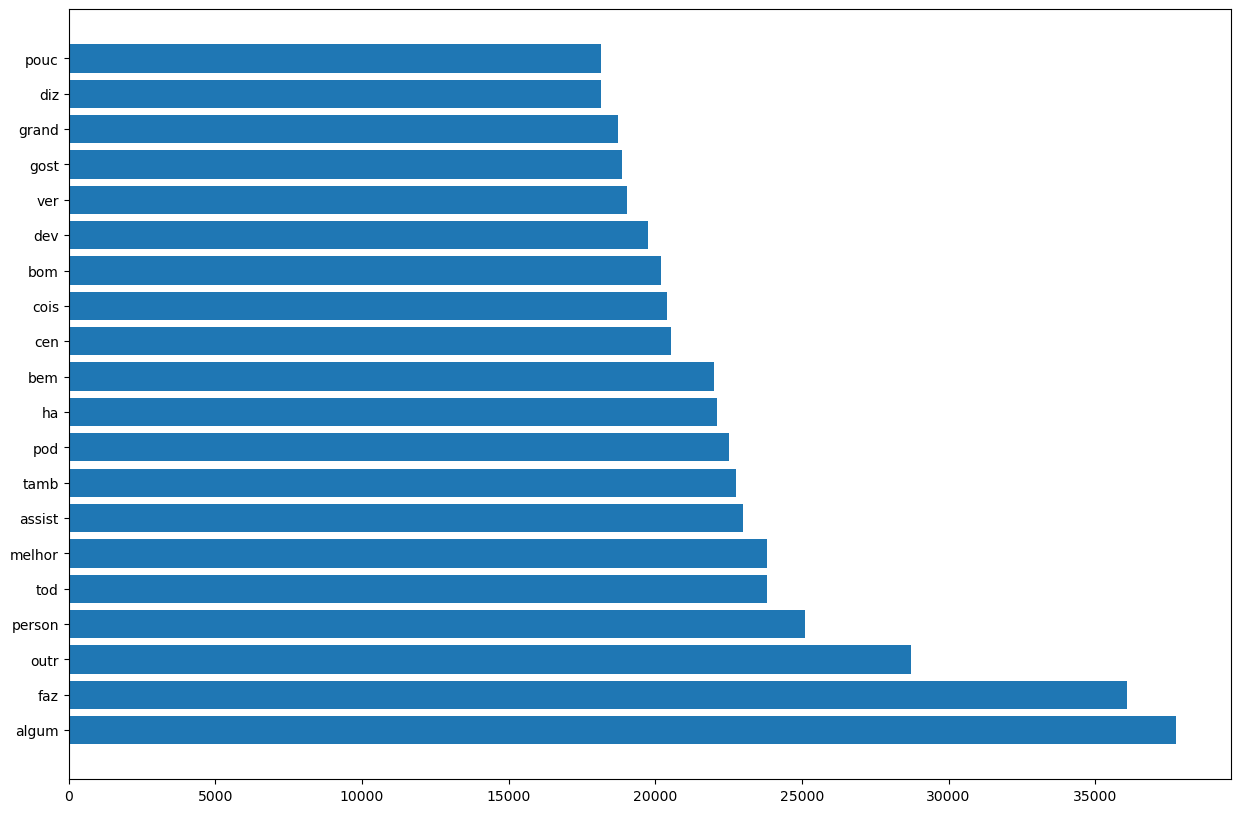

In [38]:
plt.figure(figsize=[15, 10])
plt.barh(top_20["palavras"], top_20["frequencias"])

## Trabalha a rede neural para fazer o processo de classificação

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
vetorizador = CountVectorizer(lowercase=False, max_features=200)
bow = vetorizador.fit_transform(textos)
vocabulario = vetorizador.get_feature_names_out()
bow_matrix = pd.DataFrame.sparse.from_spmatrix(bow, columns=vetorizador.get_feature_names_out())

In [40]:
from sklearn.model_selection import train_test_split
filmes_treino, filmes_teste, filmes_treino_classe, filmes_teste_classe = \
train_test_split(bow_matrix, filmes["classify"], random_state=10)

In [41]:
from sklearn.linear_model import LogisticRegression
reg_log = LogisticRegression(solver="newton-cholesky")
reg_log.fit(filmes_treino, filmes_treino_classe)

LogisticRegression(solver='newton-cholesky')

In [42]:
reg_log.score(filmes_teste, filmes_teste_classe)

0.7983825313384553